# Simulation of time evolution

Cold atomic backends are excellent simulators of physical systems as they naturally implement many Hamiltonians of interest in a controllable fashion. For example, the fermionic tweezer setup, discussed in [fermionic tweezer hardware tutorial](./03_fermionic_tweezer_hardware.ipynb), implements the Fermi-Hubbard Hamiltonian. In this tutorial we look at how such cold atomic backends can be leveraged to simulate Hamiltonian dynamics and how this can be integrated into Qiskit's structure based on problems and solvers. Typically, this will involve setting up the system in some initial state and letting it evolve under the Hamiltonian.

Specifically, we will simulate the time evolution of a fermionic lattice system. We compare how this problem is solved on the fermionic tweezer hardware and a conventional qubit hardware. This highlights how cold atomic hardware could be integrated into the Qiskit stack as a pluggable backend for certain types of problems.

The workflow consists of the following steps:

1. Define a `FermionicEvolutionProblem` made of a fermionic system, an initial state and an observable: Here, the initial state evolves under the time dynamics of the underlying system Hamiltonian. After evolution for a given time, the observable is measured.

2. Initialize a `solver` which accepts as input a backend which can be a fermionic backend or a qubit-based universal backend. Here, the fermionic backend is not universal but well-suited to simulate the specific problem as it natively implements the Hamiltonian of interest.

3. Call `solver.solve(problem)` to compute the time-dynamics of the problem. If the backend is qubit-based a mapping from fermions to qubits will be used.

## 1) Problem definition

The problem `FermionicEvolutionProblem` is a time evolution of a fermionic lattice system, after which an observable is measured. 
It consists of the following steps:

* a `system`, which describes the fermionic system to investigate. Here, we consider a 1-dimensional Fermi-Hubbard model with spin-$\frac{1}{2}$ fermions which is described by the following Hamiltonian:
    $$ H_{\text{FH}} =  J{\sum_{i=1,\sigma}^{L-1} (f^\dagger_{i,\sigma} f_{i+1,\sigma} + f^\dagger_{i+1,\sigma} f_{i,\sigma} )} + {U \sum_{i=1}^{L}  n_{i,\uparrow}n_{i,\downarrow}} + {\sum_{i=1,\sigma}^{L} \mu_i n_{i,\sigma}} $$   
As before, $J$ is the strength of the hopping between neighboring sites, $U$ is the interaction strength of two atoms on the same site, and $\mu_i$ describe local potential offsets.

In [1]:
from qiskit_cold_atom.applications import FermiHubbard1D

# defining the system 
system = FermiHubbard1D(
    num_sites = 3,          # number of lattice sites
    particles_up = 1,       # number of spin up particles
    particles_down = 1,     # number of spin down particles
    hop_strength = 2.,      # parameter J tuning the hopping 
    int_strength = 1,       # parameter U tuning the interaction
    potential = [1, 0, -1]  # parameters mu tuning the local potential
)

* The system is initialized in an initial state given as a `FermionicState` object, which describes states in occupation number basis. These occupations are given as a nested list, where the first list describes the occupations of the spin-$\uparrow$ particles and the second list denotes the occupations of the spin-$\downarrow$ particles.

In [2]:
from qiskit_cold_atom.fermions.fermion_circuit_solver import FermionicState

# defining the initial state with one spin_up particle in the left site
# and one spin-down particle in the right site
initial_state = FermionicState([[1, 0, 0], [0, 0, 1]])

* The observables to be measured after the time evolution are defined in terms of Qiskit Nature's `FermionicOp` objects:

In [3]:
from qiskit_nature.operators.second_quantization import FermionicOp

# Observables: Spin-density and particle density at the first site
spin_density = FermionicOp([('NIIIII', 1), ('IIINII', -1)])
particle_density = FermionicOp([('NIIIII', 1), ('IIINII', 1)])

* Finally, we specify the times after which these observables are measured:

In [4]:
import numpy as np
evolution_times = np.linspace(0.1, 5, 40)

We define two `FermionicEvolutionProblem` objects for the two different observables:

In [5]:
from qiskit_cold_atom.applications import FermionicEvolutionProblem

spin_problem = FermionicEvolutionProblem(system, initial_state, evolution_times, spin_density)
particle_problem = FermionicEvolutionProblem(system, initial_state, evolution_times, particle_density)

## 2) Defining the Solver

We will compare the implementations of the problem above on both qubit-based hardware and the cold atomic simulators. The solver algorithm `TimeEvolutionSolver` is intialized with a given backend which can be either a fermionic backend, such as the one introduced in [tutorial 03](./03_fermionic_tweezer_hardware.ipynb) or any qubit-based backend.

With the fermionic backend, the time-evolution is directly simulated in an analog fashion on the fermionic hardware. If the backend is a qubit-based backend, the time-evolution is simulated by trotterization, for which a fermion-to-qubit mapping and the number of trotter steps must be specified.

In [6]:
from qiskit_cold_atom.providers.fermionic_tweezer_backend import FermionicTweezerSimulator
from qiskit_cold_atom.applications import TimeEvolutionSolver

# initializing the fermionic solver
fermionic_backend = FermionicTweezerSimulator(n_tweezers=3)
fermionic_solver = TimeEvolutionSolver(backend = fermionic_backend)

We will use two qubit-based solvers. A `shallow_qubit_solver` with a small number of Trotter steps and a `deep_qubit_solver` with a larger number of Trotter steps to show the effect of Trotterization. These solvers also accept different fermion-to-qubit mappings such as the Bravyi-Kitaev, Jordan-Wigner, and the Parity mapping.

In [7]:
from qiskit import Aer

# initializing the qubit solver with the qasm simulator backend
qubit_backend = Aer.get_backend('qasm_simulator')

mapping = 'bravyi_kitaev'
# mapping = 'jordan_wigner'
# mapping = 'parity'

shallow_qubit_solver = TimeEvolutionSolver(backend = qubit_backend, map_type = mapping, trotter_steps = 1)
deep_qubit_solver = TimeEvolutionSolver(backend = qubit_backend, map_type = mapping, trotter_steps = 6)

## 3) Solve the problems and display the results

We call `solver.solve(problem)` to simulate the time evolution on the backend and measure the specified observable. The solver returns the measured expectation values at the different `evolution_times` specified in the problem. 

In [8]:
spin_vals_fermions = fermionic_solver.solve(spin_problem)
particle_vals_fermions = fermionic_solver.solve(particle_problem)

spin_vals_qubits_shallow = shallow_qubit_solver.solve(spin_problem)
particle_vals_qubits_shallow = shallow_qubit_solver.solve(particle_problem)

spin_vals_qubits_deep = deep_qubit_solver.solve(spin_problem)
particle_vals_qubits_deep = deep_qubit_solver.solve(particle_problem)

Let's plot the measured expectation values as a function of the evolution time:

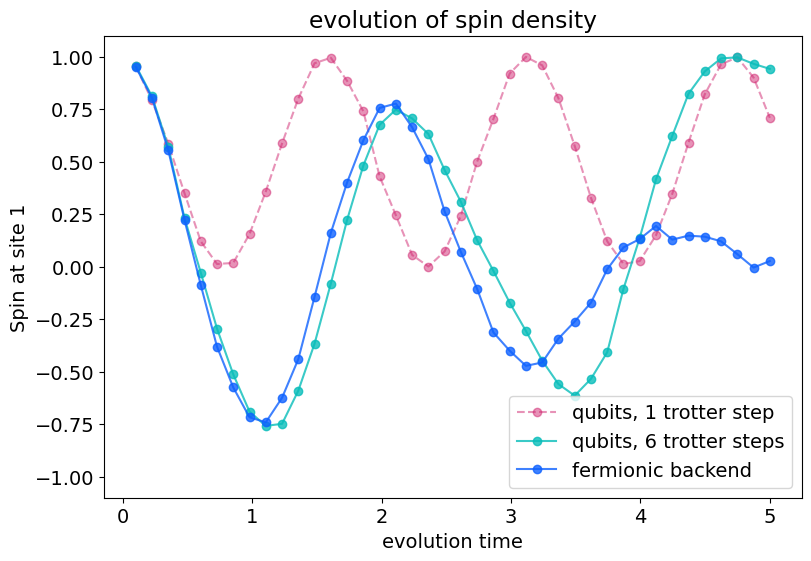

In [9]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams.update({'font.size': 14})

plt.xlabel('evolution time')
plt.ylabel('Spin at site 1')
plt.ylim(-1.1, 1.1)

plt.title('evolution of spin density')
plt.plot(evolution_times, spin_vals_qubits_shallow, '--o', color='#d02670', alpha=0.5, label='qubits, 1 trotter step')
plt.plot(evolution_times, spin_vals_qubits_deep, '-o', color='#08bdba', alpha=0.8, label='qubits, 6 trotter steps')
plt.plot(evolution_times, spin_vals_fermions, '-o', color='#0f62fe', alpha=0.8, label='fermionic backend')
plt.legend()
plt.show()

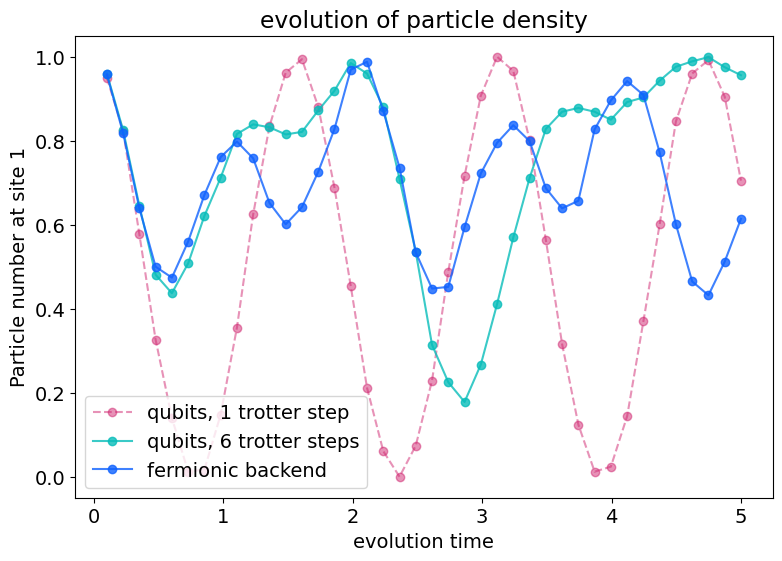

In [10]:
plt.xlabel('evolution time')
plt.ylabel('Particle number at site 1')

plt.title('evolution of particle density')
plt.plot(evolution_times, particle_vals_qubits_shallow, '--o', color='#d02670', alpha=0.5, label='qubits, 1 trotter step')
plt.plot(evolution_times, particle_vals_qubits_deep, '-o', color='#08bdba', alpha=0.8, label='qubits, 6 trotter steps')
plt.plot(evolution_times, particle_vals_fermions, '-o', color='#0f62fe', alpha=0.8, label='fermionic backend')
plt.legend()
plt.show()

We observe that for both observables, the qubit solvers that have to trotterize the circuit have trouble reproducing the results obtained by the direct simulation on the fermionic backend. The solver with one Trotter step performs particularly poorly because it can not account for the non-commuting nature of the different terms in the Fermi-Hubbard Hamiltonian.  

With a larger number of Trotter steps, the qubit solutions follow the fermionic solution well for shorter evolution times but differ significantly as the errors of the trotter steps accumulate with increasing times. 

## Circuit comparison

We now show what the quantum circuits that the solver sends to the fermionic and qubit-based backends look like. In particular, we observe that even for the very moderate system sizes employed here, the qubit-based circuits are very deep. This highlights the capability of cold atomic backends to efficiently simulate specific, hardware-native problems. 

In [11]:
fermion_circuit = spin_problem.circuits(fermionic_backend.initialize_circuit(initial_state.occupations))[-1]
fermion_circuit.measure_all()

qubit_circuit = deep_qubit_solver.construct_qubit_circuits(spin_problem)[-1]
qubit_circuit.measure_all()

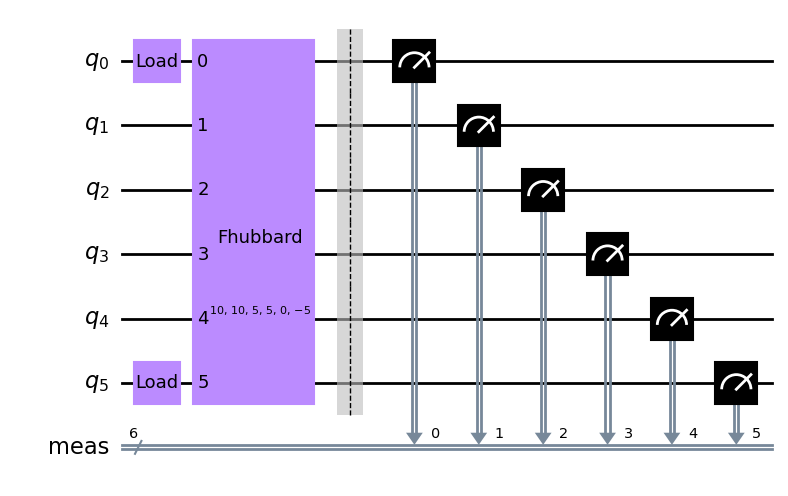

In [17]:
fermion_circuit.draw(output='mpl')

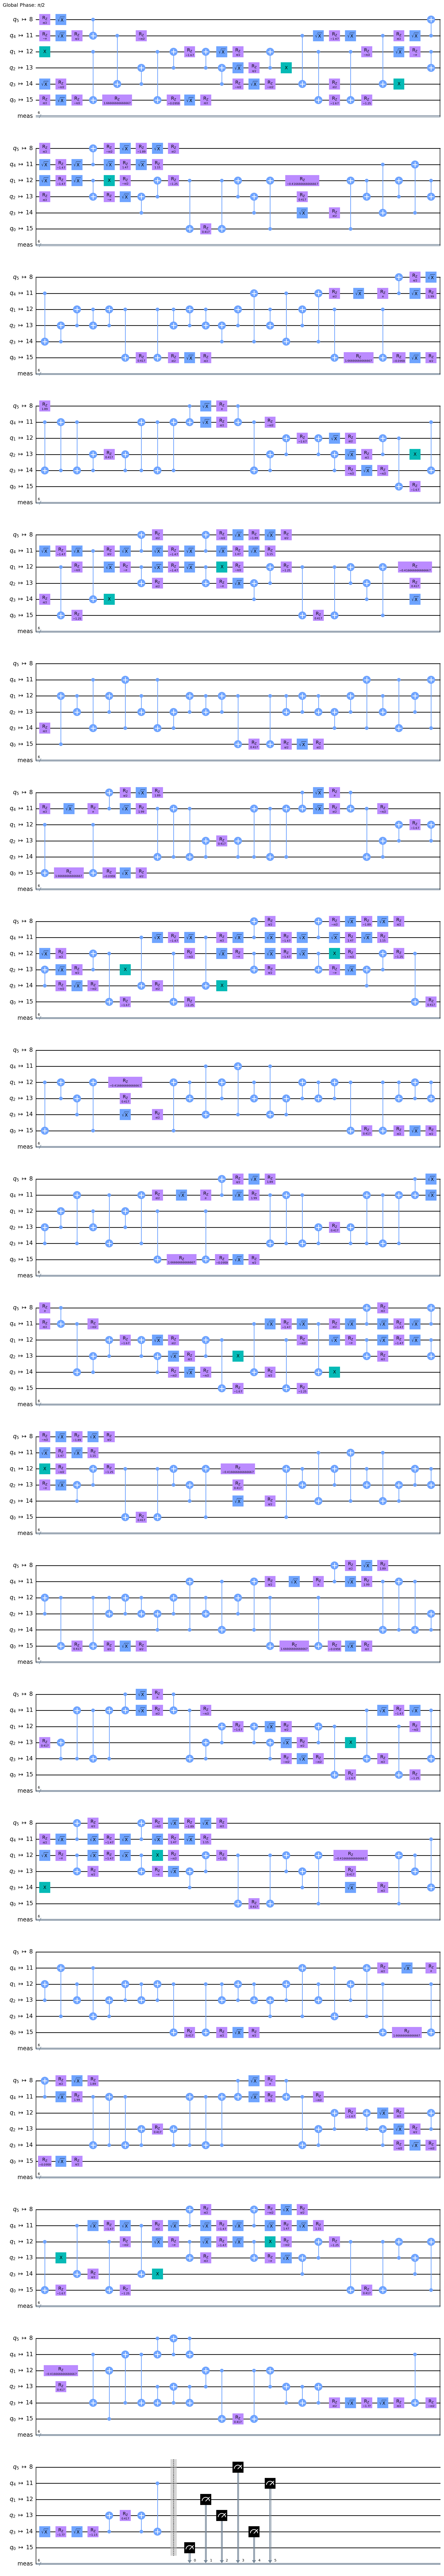

In [12]:
from qiskit import transpile
from qiskit.providers.fake_provider import FakeGuadalupe

qubit_device = FakeGuadalupe()

transpiled_circ = transpile(qubit_circuit, qubit_device, optimization_level=3)

transpiled_circ.draw(output='mpl', idle_wires=False)

In [13]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright